## Imports

In [159]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
import warnings
warnings.filterwarnings('ignore')

# import necessary libraries
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, f1_score
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import History
import warnings

# suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Exploration

In [160]:
df = pd.read_csv('./data/train.csv')
df_original = df.copy()
data_dictionary = pd.read_csv("./data/data_dictionary.csv")
print(df.shape)
df.head()

(3960, 82)


,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,Fall,5.0,4.0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.170,Fall,5.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,Summer,6.0,9.0,37.0,Summer,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,NaN,NaN,Winter,2.451,Summer,4.0,2.0,4.0,0.0,5.0,1.0,0.0,3.0,2.0,2.0,3.0,0.0,3.0,0.0,0.0,3.0,4.0,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [161]:
df = df.dropna(subset='sii') # Drop rows with missing ssi

# exclude PCIAT variables
pciat_cols = [col for col in df.columns if "PCIAT" in col]
df = df.drop(columns=pciat_cols)
df = df.drop(columns=['id'])

<Axes: >

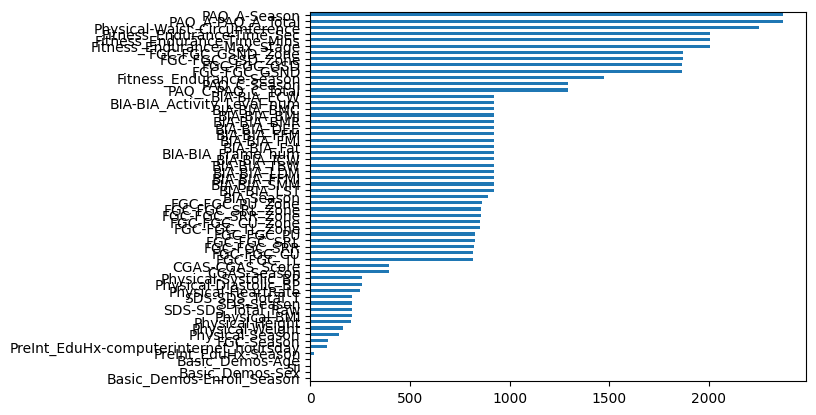

In [162]:
# Check for missing values
df.isnull().sum().sort_values(ascending=True).plot(kind='barh')

In [163]:
# address missing values in the dataset
object_columns = data_dictionary[data_dictionary['Type'].isin(['categorical int', 'str'])]['Field'].unique().tolist()
for col in df.columns:
    if col in object_columns:
        df[col] = df[col].astype('str')
        df[col] = df[col].fillna("missing")
    else:
        df[col] = df[col].fillna(0)

print(f"\nValue counts of target variable:\n{df['sii'].value_counts()}")

# encode categorical features
label_encoders = {}
for column in df.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le
    
# split data
target = "sii"
features = df.drop(columns=[target])
X_train, X_temp, y_train, y_temp = train_test_split(features, df[target], test_size=0.4, random_state=33)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=33)

df_train = X_train.copy()
df_train['sii'] = y_train


Value counts of target variable:
sii
0.0    1594
1.0     730
2.0     378
3.0      34
Name: count, dtype: int64


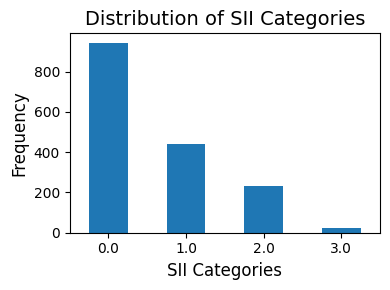

In [164]:
ax = df_train['sii'].value_counts().plot(kind='bar', figsize=(4, 3))

# Adding a title
ax.set_title('Distribution of SII Categories', fontsize=14)

# Adding axis labels
ax.set_xlabel('SII Categories', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=0, ha='center')

# Show the plot
plt.tight_layout()
plt.show()

In [165]:
# for column_name in df_train.select_dtypes(exclude=["object"]).columns:
#     df_train[column_name].plot(kind='hist', figsize=(4, 3))
#     plt.title(f"hist of {column_name}")
#     plt.show()

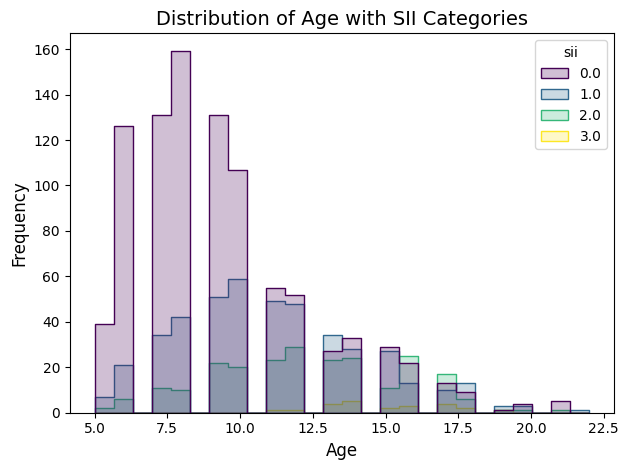

In [166]:
ax = sns.histplot(data=df_train, x='Basic_Demos-Age', hue='sii', palette='viridis', element='step')

# Adding a title
ax.set_title('Distribution of Age with SII Categories', fontsize=14)

# Adding axis labels
ax.set_xlabel('Age', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

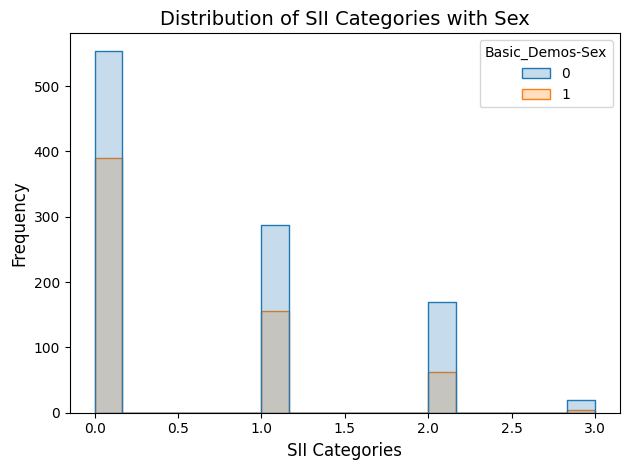

In [167]:
ax = sns.histplot(data=df_train, x='sii', hue='Basic_Demos-Sex', element='step')

# Adding a title
ax.set_title('Distribution of SII Categories with Sex', fontsize=14)

# Adding axis labels
ax.set_xlabel('SII Categories', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

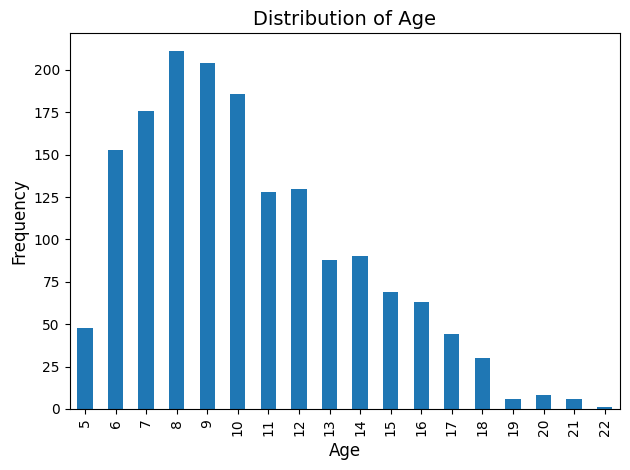

In [168]:
ax = df_train['Basic_Demos-Age'].value_counts().sort_index(
    ascending=True
).plot(kind='bar')

# Adding a title
ax.set_title('Distribution of Age', fontsize=14)

# Adding axis labels
ax.set_xlabel('Age', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

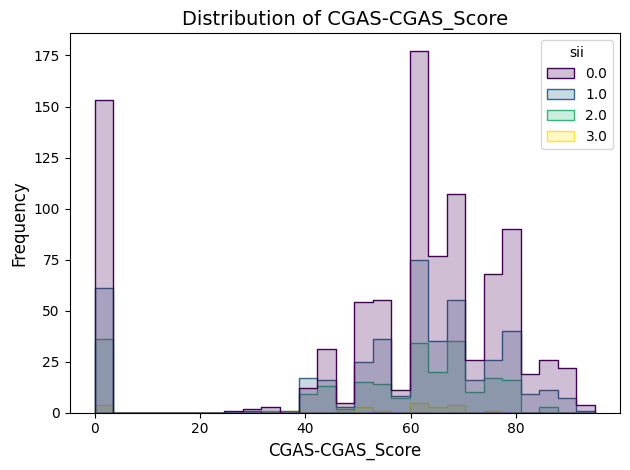

In [169]:
ax = sns.histplot(data=df_train, x='CGAS-CGAS_Score', hue='sii', palette='viridis', element='step')

# Adding a title
ax.set_title('Distribution of CGAS-CGAS_Score', fontsize=14)

# Adding axis labels
ax.set_xlabel('CGAS-CGAS_Score', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

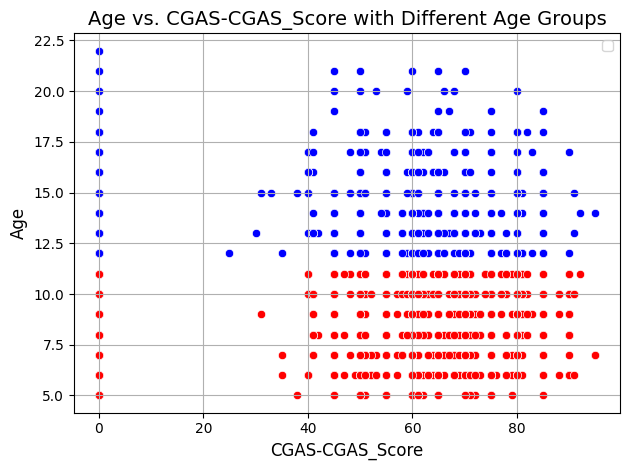

In [170]:
# How is CGAS tracking with age?
ax1 = sns.scatterplot(x='CGAS-CGAS_Score', y='Basic_Demos-Age', data=df_train[df_train['Basic_Demos-Age'] < 12], color='red')
ax2 = sns.scatterplot(x='CGAS-CGAS_Score', y='Basic_Demos-Age', data=df_train[df_train['Basic_Demos-Age'] >= 12], color='blue')
plt.grid()

# Adding a title
ax1.set_title('Age vs. CGAS-CGAS_Score with Different Age Groups', fontsize=14)

# Adding axis labels
ax1.set_xlabel('CGAS-CGAS_Score', fontsize=12)
ax1.set_ylabel('Age', fontsize=12)

# Show the plot
ax1.legend()
plt.tight_layout()
plt.show()

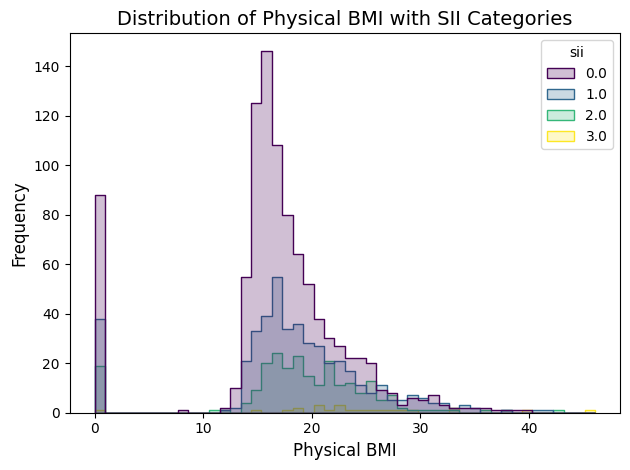

In [171]:
ax = sns.histplot(data=df_train, x='Physical-BMI', hue='sii', palette='viridis', element='step')

# Adding a title
ax.set_title('Distribution of Physical BMI with SII Categories', fontsize=14)

# Adding axis labels
ax.set_xlabel('Physical BMI', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

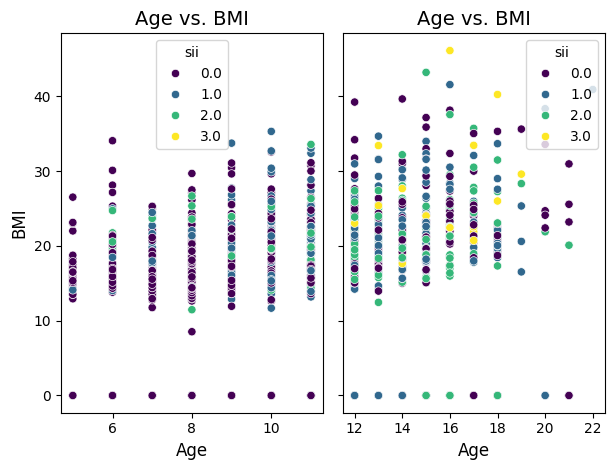

In [172]:
# How is CGAS tracking with age?
fig, ax = plt.subplots(1, 2, sharey=True)
sns.scatterplot(y='Physical-BMI', x='Basic_Demos-Age', data=df_train[df_train['Basic_Demos-Age'] < 12], hue='sii', palette='viridis', ax=ax[0])
sns.scatterplot(y='Physical-BMI', x='Basic_Demos-Age', data=df_train[df_train['Basic_Demos-Age'] >= 12], hue='sii', palette='viridis', ax=ax[1])

# Adding a title
ax[0].set_title('Age vs. BMI', fontsize=14)
ax[1].set_title('Age vs. BMI', fontsize=14)

# Adding axis labels
ax[0].set_xlabel('Age', fontsize=12)
ax[0].set_ylabel('BMI', fontsize=12)
ax[1].set_xlabel('Age', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

In [173]:
#PCIAT EDA
df_original = df_original.dropna(subset='sii') # Drop rows with missing ssi

# exclude PCIAT variables
df_subset = df_original[df_original['sii'] == 3]
pciat_cols = [col for col in df_subset.columns if "PCIAT" in col]
pciat_cols.remove("PCIAT-Season")
pciat_cols.remove('PCIAT-PCIAT_Total')

for col in pciat_cols:
    print(col + ": " + str(df_subset[col].mean()))

PCIAT-PCIAT_01: 4.705882352941177
PCIAT-PCIAT_02: 4.9411764705882355
PCIAT-PCIAT_03: 4.9411764705882355
PCIAT-PCIAT_04: 3.9411764705882355
PCIAT-PCIAT_05: 4.882352941176471
PCIAT-PCIAT_06: 4.323529411764706
PCIAT-PCIAT_07: 2.9411764705882355
PCIAT-PCIAT_08: 4.735294117647059
PCIAT-PCIAT_09: 4.352941176470588
PCIAT-PCIAT_10: 4.617647058823529
PCIAT-PCIAT_11: 3.8823529411764706
PCIAT-PCIAT_12: 1.2058823529411764
PCIAT-PCIAT_13: 4.529411764705882
PCIAT-PCIAT_14: 4.470588235294118
PCIAT-PCIAT_15: 4.705882352941177
PCIAT-PCIAT_16: 4.617647058823529
PCIAT-PCIAT_17: 4.7272727272727275
PCIAT-PCIAT_18: 4.852941176470588
PCIAT-PCIAT_19: 4.264705882352941
PCIAT-PCIAT_20: 4.411764705882353


## Feature Engineering

#### Drop columns that have more than x% missing values

In [174]:
# identify numeric features
numeric_cols = features.select_dtypes(include=["float", "int"]).columns
categorical_columns = features.select_dtypes(include=["object"]).columns

In [175]:
# standardize data
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_val[numeric_cols] = scaler.transform(X_val[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


In [176]:
# apply selectkbest feature selection after standardization
k = 20
selector = SelectKBest(score_func=mutual_info_classif, k=k)
X_train_selected = selector.fit_transform(X_train, y_train)
X_val_selected = selector.transform(X_val)
X_test_selected = selector.transform(X_test)

# retrieve feature scores and names
feature_scores = selector.scores_  
feature_names = X_train.columns

# combine and sort scores
feature_scores_df = pd.DataFrame({
    "Feature": feature_names,
    "Score": feature_scores
}).sort_values(by="Score", ascending=False)

# print top features
print(f"\nTop {k} Features Using SelectKBest:")
print(feature_scores_df.head(k))

selected_features = features.columns[selector.get_support()]
dropped_features = features.columns[~selector.get_support()]
print(f"\nSelected Features ({k}): {list(selected_features)}")
print(f"\nDropped Features ({len(list(dropped_features))}): {list(dropped_features)}")


Top 20 Features Using SelectKBest:
                                   Feature     Score
8                          Physical-Weight  0.094390
44                             BIA-BIA_ICW  0.091815
7                          Physical-Height  0.079969
1                          Basic_Demos-Age  0.078583
36                             BIA-BIA_BMR  0.062302
37                             BIA-BIA_DEE  0.060668
45                             BIA-BIA_LDM  0.057407
38                             BIA-BIA_ECW  0.055354
47                             BIA-BIA_SMM  0.051497
49                            PAQ_A-Season  0.050736
39                             BIA-BIA_FFM  0.048950
48                             BIA-BIA_TBW  0.048375
46                             BIA-BIA_LST  0.046344
21                       FGC-FGC_GSND_Zone  0.044264
57  PreInt_EduHx-computerinternet_hoursday  0.035583
16              Fitness_Endurance-Time_Sec  0.032968
20                            FGC-FGC_GSND  0.032660
22        

## Baseline Model


Confusion Matrix: Majority Baseline


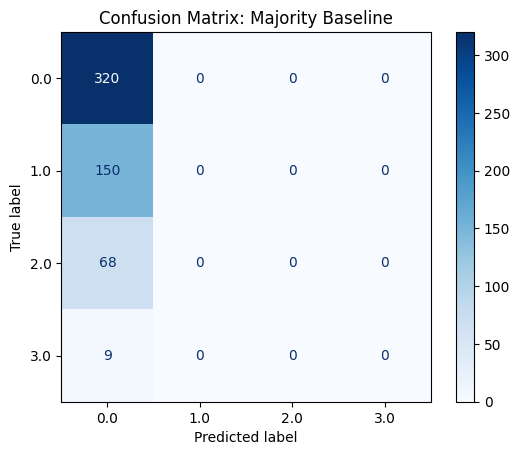

In [177]:
# majority baseline classifier for multiclass
majority_class = y_train.mode()[0]
y_pred_majority = np.full_like(y_val, fill_value=majority_class)

# binarize the target for ROC AUC
classes = np.unique(y_train)
y_train_binarized = label_binarize(y_train, classes=classes)
y_val_binarized = label_binarize(y_val, classes=classes)
roc_auc_majority = roc_auc_score(
    y_val_binarized, label_binarize(y_pred_majority, classes=classes), multi_class="ovr"
)

f1_majority = classification_report(y_val, y_pred_majority, output_dict=True)['weighted avg']['f1-score']
train_accuracy = accuracy_score(y_train, np.full_like(y_train, fill_value=majority_class))
val_accuracy = accuracy_score(y_val, y_pred_majority)

baseline_summary = {
    "Model": "Majority Baseline",
    "Train Accuracy": train_accuracy,
    "Val Accuracy": val_accuracy,
    "Train F1": f1_majority,  
    "Val F1": f1_majority,    
    "ROC AUC": roc_auc_majority,
    "Train Time (s)": 0, 
}

# confusion matrix for majority baseline
print("\nConfusion Matrix: Majority Baseline")
cm_majority = confusion_matrix(y_val, y_pred_majority)
disp_majority = ConfusionMatrixDisplay(confusion_matrix=cm_majority, display_labels=classes)
disp_majority.plot(cmap="Blues")
plt.title("Confusion Matrix: Majority Baseline")
plt.show()

print("================================================================")


## Improved Models


Training Logistic Regression...

Best Parameters: {'C': 10, 'penalty': 'l2'}
Train Acc: 0.5965874466788543
Val Acc: 0.6197440585009141
Train F1-Score: 0.5384633164851177
Val F1-Score: 0.5562575754531879
ROC AUC (OvR): 0.7412823179278143

              precision    recall  f1-score   support

         0.0       0.67      0.93      0.78       320
         1.0       0.39      0.19      0.26       150
         2.0       0.48      0.16      0.24        68
         3.0       0.00      0.00      0.00         9

    accuracy                           0.62       547
   macro avg       0.38      0.32      0.32       547
weighted avg       0.56      0.62      0.56       547



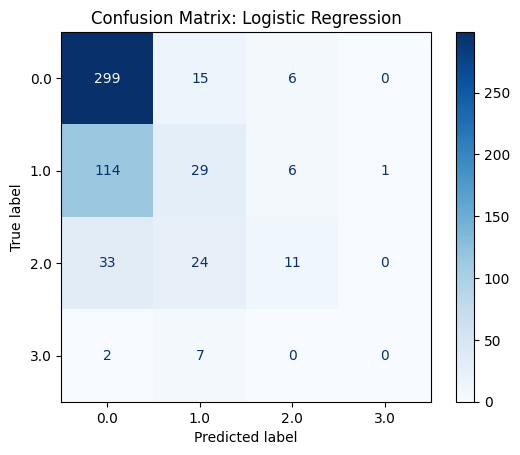


Training Random Forest...

Best Parameters: {'max_depth': 10, 'n_estimators': 200}
Train Acc: 0.894576477757465
Val Acc: 0.603290676416819
Train F1-Score: 0.8912885137819164
Val F1-Score: 0.5461830296989113
ROC AUC (OvR): 0.7161507058693485

              precision    recall  f1-score   support

         0.0       0.67      0.89      0.76       320
         1.0       0.39      0.26      0.31       150
         2.0       0.31      0.07      0.12        68
         3.0       0.00      0.00      0.00         9

    accuracy                           0.60       547
   macro avg       0.34      0.31      0.30       547
weighted avg       0.53      0.60      0.55       547



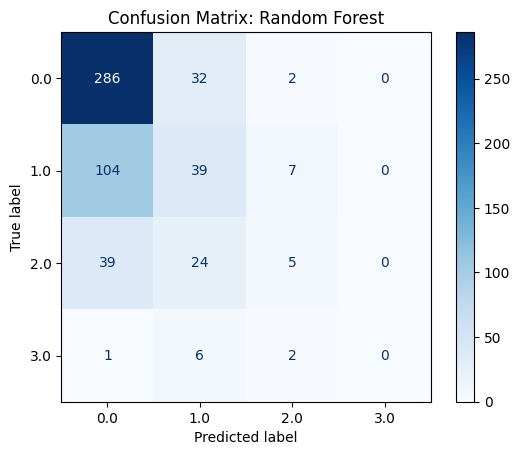


Training Gradient Boosting...

Best Parameters: {'learning_rate': 0.01, 'n_estimators': 500}
Train Acc: 0.7501523461304083
Val Acc: 0.6106032906764168
Train F1-Score: 0.7314933507952941
Val F1-Score: 0.5604690095095888
ROC AUC (OvR): 0.7354850142213003

              precision    recall  f1-score   support

         0.0       0.68      0.89      0.77       320
         1.0       0.39      0.27      0.32       150
         2.0       0.35      0.09      0.14        68
         3.0       0.17      0.11      0.13         9

    accuracy                           0.61       547
   macro avg       0.40      0.34      0.34       547
weighted avg       0.55      0.61      0.56       547



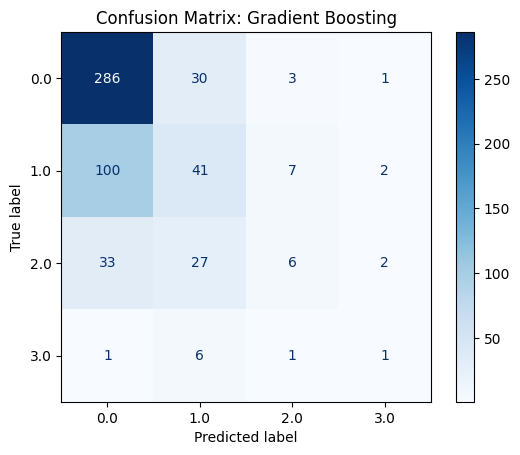

In [178]:
# Dictionary to store ROC data for each model
roc_data = {}

# models with hyperparameter tuning
models_with_params = {
    "Logistic Regression": (LogisticRegression(solver="lbfgs", multi_class="multinomial", max_iter=500), {
        "penalty": ["l2"],
        "C": [0.1, 1, 10],
    }),
    "Random Forest": (RandomForestClassifier(random_state=33), {
        "n_estimators": [50, 100, 200, 500],
        "max_depth": [5, 10, 20],
    }),
    "Gradient Boosting": (GradientBoostingClassifier(random_state=33), {
        "n_estimators": [50, 100, 200, 500],
        "learning_rate": [0.001, 0.01, 0.1, 0.2],
    }),
}

# store results for summary
summary_results = [baseline_summary]

for name, (model, param_grid) in models_with_params.items():
    print(f"\nTraining {name}...\n")
    start_time = time.time()

    # hyperparameter tuning
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring="f1_weighted", n_jobs=-1)
    grid_search.fit(X_train_selected, y_train)

    duration = time.time() - start_time
    best_model = grid_search.best_estimator_

    # validation predictions
    y_pred_train = best_model.predict(X_train_selected)
    y_pred_val = best_model.predict(X_val_selected)
    y_prob_val = best_model.predict_proba(X_val_selected)

    # metrics
    train_f1 = f1_score(y_train, y_pred_train, average="weighted")
    val_f1 = f1_score(y_val, y_pred_val, average="weighted")
    roc_auc = roc_auc_score(y_val, y_prob_val, multi_class="ovr", average="weighted")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Train Acc: {accuracy_score(y_train, y_pred_train)}")
    print(f"Val Acc: {accuracy_score(y_val, y_pred_val)}")
    print(f"Train F1-Score: {train_f1}")
    print(f"Val F1-Score: {val_f1}")
    print(f"ROC AUC (OvR): {roc_auc}\n")
    print(classification_report(y_val, y_pred_val))

    # record results
    summary_results.append({
        "Model": name,
        "Train Accuracy": accuracy_score(y_train, y_pred_train),
        "Val Accuracy": accuracy_score(y_val, y_pred_val),
        "Train F1": train_f1,
        "Val F1": val_f1,
        "ROC AUC": roc_auc,
        "Train Time (s)": duration,
    })

    # confusion matrix
    cm = confusion_matrix(y_val, y_pred_val)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_val))
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix: {name}")
    plt.show()
  
    print("================================================================")


Training FF Neural Network...
Epoch 1/100
103/103 - 2s - 16ms/step - accuracy: 0.2651 - loss: 2.2236 - val_accuracy: 0.2998 - val_loss: 1.4165
Epoch 2/100
103/103 - 0s - 3ms/step - accuracy: 0.2864 - loss: 1.7550 - val_accuracy: 0.3218 - val_loss: 1.3650
Epoch 3/100
103/103 - 0s - 2ms/step - accuracy: 0.2523 - loss: 1.8056 - val_accuracy: 0.3364 - val_loss: 1.3567
Epoch 4/100
103/103 - 0s - 2ms/step - accuracy: 0.2834 - loss: 1.6040 - val_accuracy: 0.3784 - val_loss: 1.3468
Epoch 5/100
103/103 - 0s - 3ms/step - accuracy: 0.2706 - loss: 1.5612 - val_accuracy: 0.3711 - val_loss: 1.3487
Epoch 6/100
103/103 - 0s - 3ms/step - accuracy: 0.2724 - loss: 1.5090 - val_accuracy: 0.3839 - val_loss: 1.3469
Epoch 7/100
103/103 - 0s - 3ms/step - accuracy: 0.2986 - loss: 1.4355 - val_accuracy: 0.3894 - val_loss: 1.3454
Epoch 8/100
103/103 - 0s - 2ms/step - accuracy: 0.2681 - loss: 1.4572 - val_accuracy: 0.4040 - val_loss: 1.3438
Epoch 9/100
103/103 - 0s - 2ms/step - accuracy: 0.2773 - loss: 1.4074 - 

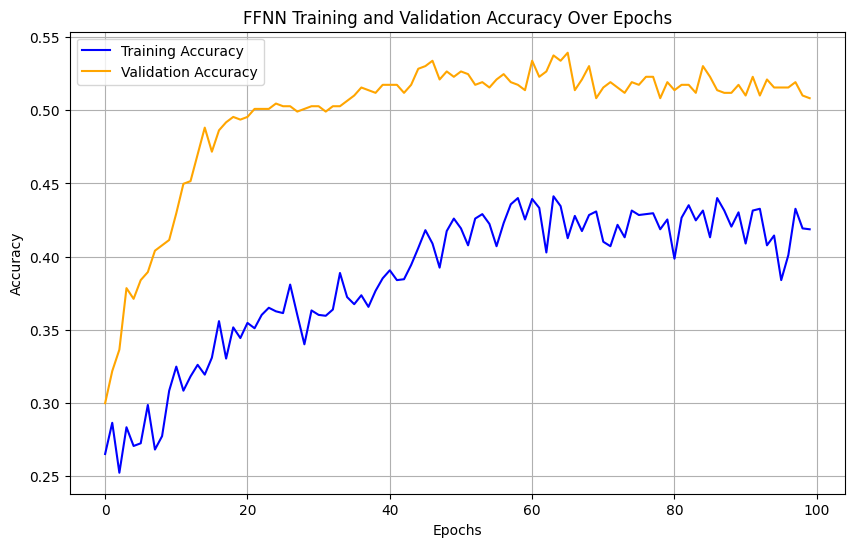

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Training Accuracy: 0.5033516148689823
Validation Accuracy: 0.5082266910420475
ROC AUC (OvR): 0.6734451499093841

              precision    recall  f1-score   support

         0.0       0.78      0.71      0.74       320
         1.0       0.32      0.13      0.18       150
         2.0       0.20      0.40      0.27        68
         3.0       0.08      0.56      0.14         9

    accuracy                           0.51       547
   macro avg       0.35      0.45      0.33       547
weighted avg       0.57      0.51      0.52       547



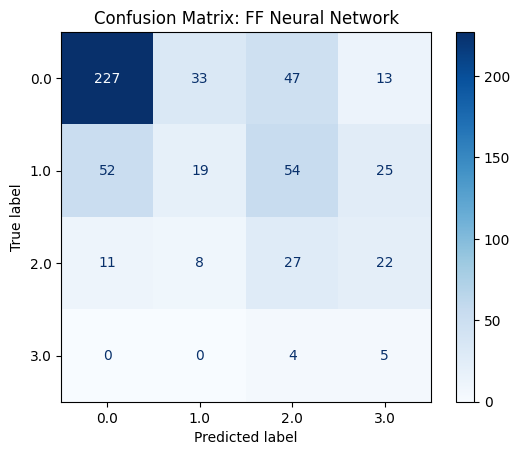

In [179]:
# Feedforward Neural Network
print("\nTraining FF Neural Network...")

# Define the FFNN model
input_dim = X_train_selected.shape[1]
model = Sequential([
    Dense(16, activation="relu", input_dim=input_dim),
    Dropout(0.5),
    Dense(16, activation="relu"),
    Dropout(0.5),
    Dense(len(np.unique(y_train)), activation="softmax")
])

from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0007)

model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train the FFNN model
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
start_time = time.time()
history = model.fit(
    X_train_selected, np.array(y_train),
    validation_data=(X_val_selected, y_val),
    epochs=100,
    batch_size=16,
    class_weight=class_weight_dict,
    verbose=2
)
duration = time.time() - start_time

# plot training and validation accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('FFNN Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Predict probabilities and labels
y_prob_val = model.predict(X_val_selected)
y_prob_train = model.predict(X_train_selected)
y_pred_train = y_prob_train.argmax(axis=1)
y_pred_val = y_prob_val.argmax(axis=1)

# Binarize the target for ROC AUC
classes = np.unique(y_train)
y_val_binarized = label_binarize(y_val, classes=classes)

# Compute Metrics
train_f1 = f1_score(y_train, y_pred_train, average="weighted")
val_f1 = f1_score(y_val, y_pred_val, average="weighted")
roc_auc_fnn = roc_auc_score(y_val_binarized, y_prob_val, multi_class="ovr", average="weighted")

# Print Results
print(f"\nTraining Accuracy: {accuracy_score(y_train, y_pred_train)}")
print(f"Validation Accuracy: {accuracy_score(y_val, y_pred_val)}")
print(f"ROC AUC (OvR): {roc_auc_fnn}\n")
print(classification_report(y_val, y_pred_val))

# Record FFNN results
summary_results.append({
    "Model": "FF Neural Network",
    "Train Accuracy": accuracy_score(y_train, y_pred_train),
    "Val Accuracy": accuracy_score(y_val, y_pred_val),
    "Train F1": train_f1,
    "Val F1": val_f1,
    "ROC AUC": roc_auc_fnn,
    "Train Time (s)": duration,
})

# confusion matrix for FFNN
cm_fnn = confusion_matrix(y_val, y_pred_val)
disp_fnn = ConfusionMatrixDisplay(confusion_matrix=cm_fnn, display_labels=classes)
disp_fnn.plot(cmap="Blues")
plt.title("Confusion Matrix: FF Neural Network")
plt.show()

## Results

In [180]:
# display summary results
summary_df = pd.DataFrame(summary_results)
print("\nMulticlass, All Ages\nSummary Results:")
print(summary_df)


Multiclass, All Ages
Summary Results:
                 Model  Train Accuracy  Val Accuracy  Train F1    Val F1  \
0    Majority Baseline        0.574650      0.585009  0.431841  0.431841   
1  Logistic Regression        0.596587      0.619744  0.538463  0.556258   
2        Random Forest        0.894576      0.603291  0.891289  0.546183   
3    Gradient Boosting        0.750152      0.610603  0.731493  0.560469   
4    FF Neural Network        0.503352      0.508227  0.507606  0.520810   

    ROC AUC  Train Time (s)  
0  0.500000        0.000000  
1  0.741282       11.657489  
2  0.716151        5.506313  
3  0.735485       37.773851  
4  0.673445       30.240519  
